# CAPSTONE
Kehinde Ajayi

Initial modeling

In [3]:
# from google.colab import auth
# auth.authenticate_user()

# # https://cloud.google.com/resource-manager/docs/creating-managing-projects
# project_id = 'capstone2022-349201'

In [4]:
!pwd


/home/kajayi/Capstone/ka_capstone/notebooks


In [5]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi --pre deepchem
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

import sys

from tqdm.auto import tqdm

import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools

import deepchem as dc
import tensorflow as tf
from deepchem.models import GraphConvModel
from deepchem.models.layers import GraphConv, GraphPool, GraphGather

from scipy.sparse import coo_matrix  #yes
from scipy.sparse import csr_matrix  #yes

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.multiclass import unique_labels, type_of_target 
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, classification_report


In [2]:
tf.config.list_physical_devices('GPU')

2022-07-21 00:52:39.659592: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-21 00:52:39.659642: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (first-one): /proc/driver/nvidia/version does not exist


[]

In [91]:
rdkit.__version__



'2022.03.2'

## Functions and settings

In [10]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [11]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    file_path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    file_path = '..'
  
  return file_path


In [12]:
# GCN model

def generate_gcnn_model(n_tasks=1, mode='classification'):
    """Instantiates a Graph Convolution model.

    Args:
        param1: The first parameter.
        param2: The second parameter.

    Returns:
        The return value. True for success, False otherwise.

    """
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size,
                         graph_conv_layers=[128, 128],
                         dense_layer_size=256,
                         mode='classification',
                         model_dir=f'{get_home_path()}/models')
    return model

In [13]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

In [14]:
def evaluate_model(modelx, hist, save_dir):
    
    modelx.restore(model_dir=save_dir)
    print('Training set score:', modelx.evaluate(train_dataset, metrics))
    print('Validation set score:', modelx.evaluate(valid_dataset, metrics))
    print('Test set score:', modelx.evaluate(test_dataset, metrics))

    
    modelx.restore(model_dir=f'{save_dir}/callbacks')
    print('Best validation set score:', modelx.evaluate(valid_dataset, metrics))

    print(f'Loss? = {hist}')

    pred = [x.flatten() for x in modelx.predict(valid_dataset)]

    cm = confusion_matrix(valid_dataset.y, [round(x[1]) for x in pred])
    print(cm)

    tn, fp, fn, tp = cm.ravel()

    # specificity
    print(f'Specificity = {round(tn/(tn+fp), 4)}')

    # 1- specificity
    print(f'FPR = {round(fp/(tn+fp), 4)}')

    # sensitivity
    print(f'Recall/TPR = {round(tp/(tp+fn), 4)}')

    print(f'Precision = {round(tp/(tp+fp), 4)}')
    


In [15]:

# ## code adapted from Scikit-learn's confusion_matrix function

# def _cust_check_targets(y_true, y_pred):
#     """Check that y_true and y_pred belong to the same classification task.
#     This converts multiclass or binary types to a common shape, and raises a
#     ValueError for a mix of multilabel and multiclass targets, a mix of
#     multilabel formats, for the presence of continuous-valued or multioutput
#     targets, or for targets of different lengths.
#     Column vectors are squeezed to 1d, while multilabel formats are returned
#     as CSR sparse label indicators.
#     Parameters
#     ----------
#     y_true : array-like
#     y_pred : array-like
#     Returns
#     -------
#     type_true : one of {'multilabel-indicator', 'multiclass', 'binary'}
#         The type of the true target data, as output by
#         ``utils.multiclass.type_of_target``.
#     y_true : array or indicator matrix
#     y_pred : array or indicator matrix
#     """
#     check_consistent_length(y_true, y_pred)
#     type_true = type_of_target(y_true)
#     type_pred = type_of_target(y_pred)

#     y_type = {type_true, type_pred}
#     if y_type == {"binary", "multiclass"}:
#         y_type = {"multiclass"}

#     if len(y_type) > 1:
#         raise ValueError(
#             "Classification metrics can't handle a mix of {0} and {1} targets".format(
#                 type_true, type_pred
#             )
#         )

#     # We can't have more than one value on y_type => The set is no more needed
#     y_type = y_type.pop()

#     # No metrics support "multiclass-multioutput" format
#     if y_type not in ["binary", "multiclass", "multilabel-indicator"]:
#         raise ValueError("{0} is not supported".format(y_type))

#     if y_type in ["binary", "multiclass"]:
#         y_true = column_or_1d(y_true)
#         y_pred = column_or_1d(y_pred)
#         if y_type == "binary":
#             try:
#                 unique_values = np.union1d(y_true, y_pred)
#             except TypeError as e:
#                 # We expect y_true and y_pred to be of the same data type.
#                 # If `y_true` was provided to the classifier as strings,
#                 # `y_pred` given by the classifier will also be encoded with
#                 # strings. So we raise a meaningful error
#                 raise TypeError(
#                     "Labels in y_true and y_pred should be of the same type. "
#                     f"Got y_true={np.unique(y_true)} and "
#                     f"y_pred={np.unique(y_pred)}. Make sure that the "
#                     "predictions provided by the classifier coincides with "
#                     "the true labels."
#                 ) from e
#             if len(unique_values) > 2:
#                 y_type = "multiclass"

#     if y_type.startswith("multilabel"):
#         y_true = csr_matrix(y_true)
#         y_pred = csr_matrix(y_pred)
#         y_type = "multilabel-indicator"

#     return y_type, y_true, y_pred



# def cust_confusion_matrix(
#     y_true, y_pred, *, labels=None, sample_weight=None, normalize=None
# ):
#     """Compute confusion matrix to evaluate the accuracy of a classification.
#     By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
#     is equal to the number of observations known to be in group :math:`i` and
#     predicted to be in group :math:`j`.
#     Thus in binary classification, the count of true negatives is
#     :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
#     :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
#     Read more in the :ref:`User Guide <confusion_matrix>`.
#     Parameters
#     ----------
#     y_true : array-like of shape (n_samples,)
#         Ground truth (correct) target values.
#     y_pred : array-like of shape (n_samples,)
#         Estimated targets as returned by a classifier.
#     labels : array-like of shape (n_classes), default=None
#         List of labels to index the matrix. This may be used to reorder
#         or select a subset of labels.
#         If ``None`` is given, those that appear at least once
#         in ``y_true`` or ``y_pred`` are used in sorted order.
#     sample_weight : array-like of shape (n_samples,), default=None
#         Sample weights.
#         .. versionadded:: 0.18
#     normalize : {'true', 'pred', 'all'}, default=None
#         Normalizes confusion matrix over the true (rows), predicted (columns)
#         conditions or all the population. If None, confusion matrix will not be
#         normalized.
#     Returns
#     -------
#     C : ndarray of shape (n_classes, n_classes)
#         Confusion matrix whose i-th row and j-th
#         column entry indicates the number of
#         samples with true label being i-th class
#         and predicted label being j-th class.
#     See Also
#     --------
#     ConfusionMatrixDisplay.from_estimator : Plot the confusion matrix
#         given an estimator, the data, and the label.
#     ConfusionMatrixDisplay.from_predictions : Plot the confusion matrix
#         given the true and predicted labels.
#     ConfusionMatrixDisplay : Confusion Matrix visualization.
#     References
#     ----------
#     .. [1] `Wikipedia entry for the Confusion matrix
#            <https://en.wikipedia.org/wiki/Confusion_matrix>`_
#            (Wikipedia and other references may use a different
#            convention for axes).
#     Examples
#     --------
#     >>> from sklearn.metrics import confusion_matrix
#     >>> y_true = [2, 0, 2, 2, 0, 1]
#     >>> y_pred = [0, 0, 2, 2, 0, 2]
#     >>> confusion_matrix(y_true, y_pred)
#     array([[2, 0, 0],
#            [0, 0, 1],
#            [1, 0, 2]])
#     >>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
#     >>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
#     >>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
#     array([[2, 0, 0],
#            [0, 0, 1],
#            [1, 0, 2]])
#     In the binary case, we can extract true positives, etc as follows:
#     >>> tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
#     >>> (tn, fp, fn, tp)
#     (0, 2, 1, 1)
#     """
#     y_type, y_true, y_pred = _cust_check_targets(y_true, y_pred)
#     if y_type not in ("binary", "multiclass"):
#         raise ValueError("%s is not supported" % y_type)

#     if labels is None:
#         labels = unique_labels(y_true, y_pred)
#     else:
#         labels = np.asarray(labels)
#         n_labels = labels.size
#         if n_labels == 0:
#             raise ValueError("'labels' should contains at least one label.")
#         elif y_true.size == 0:
#             return np.zeros((n_labels, n_labels), dtype=int)
#         elif len(np.intersect1d(y_true, labels)) == 0:
#             raise ValueError("At least one label specified must be in y_true")

#     if sample_weight is None:
#         sample_weight = np.ones(y_true.shape[0], dtype=np.int64)
#     else:
#         sample_weight = np.asarray(sample_weight)

#     check_consistent_length(y_true, y_pred, sample_weight)

#     if normalize not in ["true", "pred", "all", None]:
#         raise ValueError("normalize must be one of {'true', 'pred', 'all', None}")

#     n_labels = labels.size
#     # If labels are not consecutive integers starting from zero, then
#     # y_true and y_pred must be converted into index form
#     need_index_conversion = not (
#         labels.dtype.kind in {"i", "u", "b"}
#         and np.all(labels == np.arange(n_labels))
#         and y_true.min() >= 0
#         and y_pred.min() >= 0
#     )
#     if need_index_conversion:
#         label_to_ind = {y: x for x, y in enumerate(labels)}
#         y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
#         y_true = np.array([label_to_ind.get(x, n_labels + 1) for x in y_true])

#     # intersect y_pred, y_true with labels, eliminate items not in labels
#     ind = np.logical_and(y_pred < n_labels, y_true < n_labels)
#     if not np.all(ind):
#         y_pred = y_pred[ind]
#         y_true = y_true[ind]
#         # also eliminate weights of eliminated items
#         sample_weight = sample_weight[ind]

#     # Choose the accumulator dtype to always have high precision
#     if sample_weight.dtype.kind in {"i", "u", "b"}:
#         dtype = np.int64
#     else:
#         dtype = np.float64

#     cm = coo_matrix(
#         (sample_weight, (y_true, y_pred)),
#         shape=(n_labels, n_labels),
#         dtype=dtype,
#     ).toarray()

#     with np.errstate(all="ignore"):
#         if normalize == "true":
#             cm = cm / cm.sum(axis=1, keepdims=True)
#         elif normalize == "pred":
#             cm = cm / cm.sum(axis=0, keepdims=True)
#         elif normalize == "all":
#             cm = cm / cm.sum()
#         cm = np.nan_to_num(cm)

#     return cm


## Read data

In [16]:
    
# read hERG data into dataframe 
herg_df = pd.read_csv(f'{get_home_path()}/data/interim/herg_data.csv')


## Initial model

In [18]:

herg_df.sample(5)

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label
132554,47194915,O=c1oc2ccccc2n1Cc1cccc(C(F)(F)F)c1,4.8772,-9.86412,0,293.244,3.66160,35.14,0,3,6,3,3,2,0,0,34,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n...,inactive
246388,7965435,O=C(Nc1ccccc1F)C1CCCN(S(=O)(=O)c2cccc3cccnc23)C1,2.7917,1.36368,0,413.474,3.41330,79.37,1,4,8,4,3,4,1,0,48,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive
138028,49828138,Cc1cc(C(=O)NC2CCC(C)CC2)c(C)o1,7.3915,12.46638,0,235.327,3.20494,42.24,1,2,3,2,1,2,0,0,30,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 ...,inactive
58110,24824071,CCOc1ccc(/C=N/NC(=O)CNC(=O)c2ccc(S(=O)(=O)N3CC...,14.4227,11.70228,0,474.539,0.98630,126.40,2,7,11,3,2,9,0,0,58,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive
263364,49728119,COc1cc(OC)cc(C(=O)N2CCCC(c3nc(-c4ccc(C)o4)no3)...,16.2872,-9.34562,0,397.431,3.67502,90.83,0,7,8,4,3,5,1,0,51,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive


### Create dataset for Graph Convolutional NN


**From Duvenaud:**  

Experimental setup -  Our pipeline takes as input the SMILES [30] string encoding of each
molecule, which is then converted into a graph using RDKit [20]. We also used RDKit to produce
the extended circular fingerprints used in the baseline. Hydrogen atoms were treated implicitly.  

In our convolutional networks, the initial atom and bond features were chosen to be similar to those
used by ECFP: Initial atom features concatenated a one-hot encoding of *the atom’s element, its
degree, the number of attached hydrogen atoms, and the implicit valence, and an aromaticity indicator.* The bond features were a concatenation of whether the bond type was single, double, triple,
or aromatic, whether the bond was conjugated, and whether the bond was part of a ring.

In [19]:
## load dataset if it exists and create it if it doesn't
try:
    # load saved dataset
    dataset = dc.data.DiskDataset('../data/processed/ConvMolFeatures')
except ValueError:
    # create dataset
    dataset_file = f'{get_home_path()}/data/interim/herg_data.csv'
    tasks = ['herg_inhibitor']
    featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks,
                               feature_field='SMILES',
                               featurizer=featurizer)
    dataset = loader.create_dataset(dataset_file, f'{get_home_path()}/data/processed/ConvMolFeatures', shard_size=8192)

In [20]:

dataset

<DiskDataset X.shape: (306865,), y.shape: (306865, 1), w.shape: (306865, 1), task_names: ['herg_inhibitor']>

In [21]:
# split dataset into training, validation, and testing sets
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

In [22]:
print(dataset)

<DiskDataset X.shape: (306865,), y.shape: (306865, 1), w.shape: (306865, 1), task_names: ['herg_inhibitor']>


In [23]:
type(dataset.y)

numpy.ndarray

In [21]:
# dc.utils.data_utils.save_to_disk(dataset, filename='../data/processed/deepchem_dataset')

In [24]:
# define metrics used to evaluate model
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode='classification'), dc.metrics.Metric(dc.metrics.accuracy_score, np.mean, mode='classification'), dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode='classification')]

In [25]:
dataset.data_dir

'../data/processed/ConvMolFeatures'

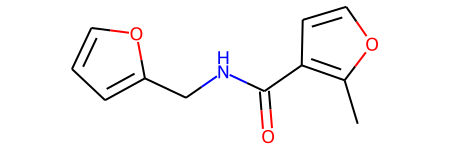

In [26]:
Chem.MolFromSmiles(herg_df.SMILES[0])

In [27]:
print(herg_df.adjacency_matrix[0])

[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0]]


In [28]:
# Inspect features for molecule 0
conv_feature = train_dataset.X[0]
# Print the atom features
print(conv_feature.get_atom_features())
# Print the adjacency list
print(conv_feature.get_adjacency_list())

[[1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[13], [12], [4, 11], [9, 14], [7, 2], [11, 7], [12, 10], [5, 4], [13, 9], [8, 3], [6, 11], [10, 5, 2], [14, 1, 6], [0, 8, 14], [3, 12, 13]]


In [29]:
conv_feature.get_deg_adjacency_lists()

[array([], shape=(0, 0), dtype=int32),
 array([[13],
        [12]], dtype=int32),
 array([[ 4, 11],
        [ 9, 14],
        [ 7,  2],
        [11,  7],
        [12, 10],
        [ 5,  4],
        [13,  9],
        [ 8,  3],
        [ 6, 11]], dtype=int32),
 array([[10,  5,  2],
        [14,  1,  6],
        [ 0,  8, 14],
        [ 3, 12, 13]], dtype=int32),
 array([], shape=(0, 4), dtype=int32),
 array([], shape=(0, 5), dtype=int32),
 array([], shape=(0, 6), dtype=int32),
 array([], shape=(0, 7), dtype=int32),
 array([], shape=(0, 8), dtype=int32),
 array([], shape=(0, 9), dtype=int32),
 array([], shape=(0, 10), dtype=int32)]

In [30]:
dir(conv_feature)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deg_sort',
 'agglomerate_mols',
 'atom_features',
 'canon_adj_list',
 'deg_adj_lists',
 'deg_block_indices',
 'deg_id_list',
 'deg_list',
 'deg_slice',
 'deg_start',
 'degree_list',
 'get_adjacency_list',
 'get_atom_features',
 'get_atoms_with_deg',
 'get_deg_adjacency_lists',
 'get_deg_slice',
 'get_null_mol',
 'get_num_atoms',
 'get_num_atoms_with_deg',
 'max_deg',
 'membership',
 'min_deg',
 'n_atoms',
 'n_feat']

In [33]:
conv_feature.agglomerate_mols

<function deepchem.feat.mol_graphs.ConvMol.agglomerate_mols(mols, max_deg=10, min_deg=0)>

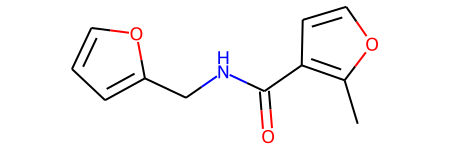

In [34]:
Chem.MolFromSmiles(herg_df.SMILES[0])

### Run models

In [21]:
# training_score_list = []
# validation_score_list = []
# transformers = []
# cv_folds = 5
# for i in range(0, cv_folds):
#   model = generate_gcnn_model()
#   train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
#   model.fit(train_dataset)
#   train_scores = model.evaluate(train_dataset,
#                                 metrics,
#                                 transformers)
#   training_score_list.append(train_scores["mean-matthews_corrcoef"])
#   validation_scores = model.evaluate(valid_dataset,
#                                      metrics,
#                                      transformers)
#   validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
#   print(training_score_list)
#   print(validation_score_list)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_14:0", shape=(531,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_13:0", shape=(531, 128), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_17:0", shape=(3340,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_

ValueError: metrics must be one of metric function / dc.metrics.Metric object /list of dc.metrics.Metric or metric functions.

In [26]:
model = generate_gcnn_model()

In [41]:
model.fit(train_dataset, nb_epoch=100)

0.02195476144552231

In [42]:
print('Training set score:', model.evaluate(train_dataset, metrics, transformers))
print('Test set score:', model.evaluate(test_dataset, metrics, transformers))

Training set score: {'mean-matthews_corrcoef': 0.8986171319786729, 'mean-accuracy_score': 0.9916820100043994}
Test set score: {'mean-matthews_corrcoef': 0.4466402519674134, 'mean-accuracy_score': 0.9598852934467365}


NotImplementedError: 

# model results

1. 2 GCN layers; 128 neurons each, with 20 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.6428713584722922, 'mean-accuracy_score': 0.9734085021100484}  
Test set score: {'mean-matthews_corrcoef': 0.4787317574971372, 'mean-accuracy_score': 0.9628833056343077}  

2. 2 GCN layers; 128 neurons each, with 100 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.8986171319786729, 'mean-accuracy_score': 0.9916820100043994}  
Test set score: {'mean-matthews_corrcoef': 0.4466402519674134, 'mean-accuracy_score': 0.9598852934467365}
---
3. 2 GCN layers; 128 neurons each, 1-layer FNN (256); with 100 epochs, with 20% dropout:   
Training set score: {'mean-matthews_corrcoef': 0.45850212856054634, 'mean-accuracy_score': 0.964960161634595}  
Validation set score: {'mean-matthews_corrcoef': 0.3731441911144923, 'mean-accuracy_score': 0.9615133937300397}  
Test set score: {'mean-matthews_corrcoef': 0.37520900721711353, 'mean-accuracy_score': 0.9615472349854988}  

4. 2 GCN layers (128, 256); 1-layer FNN (256); 100 epochs; with 20% dropout:   
Training set score: {'mean-matthews_corrcoef': 0.4142104435615528, 'mean-accuracy_score': 0.9632004301565835}  
Validation set score: {'mean-matthews_corrcoef': 0.3484192642848399, 'mean-accuracy_score': 0.9608616307110734}  
Test set score: {'mean-matthews_corrcoef': 0.330927336552633, 'mean-accuracy_score': 0.9602111643366898}  

5.  3 GCN layers (64, 128, 256); 1-layer FNN (256); 100 epochs; 20% dropout:   
Training set score: {'mean-matthews_corrcoef': 0.5025293293380898, 'mean-accuracy_score': 0.9669235657373764}  
Validation set score: {'mean-matthews_corrcoef': 0.37836007619427664, 'mean-accuracy_score': 0.9616763344847813}  
Test set score: {'mean-matthews_corrcoef': 0.40029470609974166, 'mean-accuracy_score': 0.9624270863883729}  

6. 2 GCN layers; 128 neurons each, 1-layer FNN (256); with 300 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.980639353687451, 'mean-accuracy_score': 0.9983543251918596}  
Validation set score: {'mean-matthews_corrcoef': 0.4669227968724198, 'mean-accuracy_score': 0.9597536335788307}  
Test set score: {'mean-matthews_corrcoef': 0.43511600018388047, 'mean-accuracy_score': 0.9573109134161045}  
loss? 0.01113940954208374

7. 2 GCN layers (512, 1024); 1-layer FNN (256); 20 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.6449390262476722, 'mean-accuracy_score': 0.9708625943004253}  
Validation set score: {'mean-matthews_corrcoef': 0.4749802086322286, 'mean-accuracy_score': 0.9571791696539138}  
Test set score: {'mean-matthews_corrcoef': 0.49445900413598426, 'mean-accuracy_score': 0.9600156418027178}  
loss? 0.08594311078389485  
Best validation set score: {'mean-matthews_corrcoef': 0.48013768550166536, 'mean-accuracy_score': 0.9623280975037476}

8. 2 GCN layers (1024, 2048); 1-layer FNN (256); 20 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.5892717340747637, 'mean-accuracy_score': 0.9709155491828654}  
Validation set score: {'mean-matthews_corrcoef': 0.44678468227552504, 'mean-accuracy_score': 0.9629472723717656}  
Test set score: {'mean-matthews_corrcoef': 0.4300309731397157, 'mean-accuracy_score': 0.9623293251213869}  
loss? 0.08380654652913412  
Best validation set score: {'mean-matthews_corrcoef': 0.4794959701248735, 'mean-accuracy_score': 0.9537574138043408}  
[[28548   764]  
 [  655   719]]  
Specificity = 0.9739  
FPR = 0.0261  
Recall/TPR = 0.5233  
Precision = 0.4848  


9. 2 GCN layers (256, 512); 1-layer FNN (256); 20 epochs:   
Training set score: {'mean-matthews_corrcoef': 0.6073488599104414, 'mean-accuracy_score': 0.9714043634823131}  
Validation set score: {'mean-matthews_corrcoef': 0.45385158253018826, 'mean-accuracy_score': 0.9619044515414196}  
Test set score: {'mean-matthews_corrcoef': 0.45851465260990887, 'mean-accuracy_score': 0.9628507185453123}  
Best validation set score: {'mean-matthews_corrcoef': 0.475989831688181, 'mean-accuracy_score': 0.9620999804471094}  
Loss? = 0.08921345869700113  
[[28983   329]  
 [  834   540]]  
Specificity = 0.9888  
FPR = 0.0112  
Recall/TPR = 0.393  
Precision = 0.6214  

10. 2 GCN layers (1024, 512); 1-layer FNN (256); 20 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.6335385781975322, 'mean-accuracy_score': 0.9702923109510697, 'mean-roc_auc_score': 0.961515084775735}  
Validation set score: {'mean-matthews_corrcoef': 0.4787927575103589, 'mean-accuracy_score': 0.9584501075408981, 'mean-roc_auc_score': 0.9025637020453146}  
Test set score: {'mean-matthews_corrcoef': 0.45549041923086453, 'mean-accuracy_score': 0.9574412617720859, 'mean-roc_auc_score': 0.8991438760820261}  
Best validation set score: {'mean-matthews_corrcoef': 0.47967790456375287, 'mean-accuracy_score': 0.9603728084468487, 'mean-roc_auc_score': 0.9118796090983995}  
Loss? = 0.09841734568277995  
[[28875   437]  
 [  779   595]]  
Specificity = 0.9851  
FPR = 0.0149  
Recall/TPR = 0.433  
Precision = 0.5766  

11. 2 GCN layers (512, 1024); 1-layer FNN (256); 200 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.9886646777979844, 'mean-accuracy_score': 0.9990305183060955, 'mean-roc_auc_score': 0.9999464164108443}  
Validation set score: {'mean-matthews_corrcoef': 0.47246252561496016, 'mean-accuracy_score': 0.9592322231636577, 'mean-roc_auc_score': 0.8847153576956326}  
Test set score: {'mean-matthews_corrcoef': 0.45208120822716674, 'mean-accuracy_score': 0.9575390230390719, 'mean-roc_auc_score': 0.8811270699702469}  
Best validation set score: {'mean-matthews_corrcoef': 0.5072253130749046, 'mean-accuracy_score': 0.9620999804471094, 'mean-roc_auc_score': 0.9022784670609987}  
Loss? = 0.005859992504119873  
[[28888   424]  
 [  739   635]]  
Specificity = 0.9855  
FPR = 0.0145  
Recall/TPR = 0.4622  
Precision = 0.5996  

12. 2 GCN layers (512, 1024); 1-layer FNN (256); 100 epochs; 40% dropout:  NO GOOD!


13. 3 GCN layers (64, 256, 1024); 1-layer FNN (256); 50 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.909140121876442, 'mean-accuracy_score': 0.9923948641910938, 'mean-roc_auc_score': 0.998363235694375}  
Validation set score: {'mean-matthews_corrcoef': 0.4833174530782624, 'mean-accuracy_score': 0.9604379847487453, 'mean-roc_auc_score': 0.8920752781498891}  
Test set score: {'mean-matthews_corrcoef': 0.4723276007506134, 'mean-accuracy_score': 0.9602437514256852, 'mean-roc_auc_score': 0.8915162808121608}  
Best validation set score: {'mean-matthews_corrcoef': 0.5157338258031209, 'mean-accuracy_score': 0.9591018705598644, 'mean-roc_auc_score': 0.9039374184599518}  
Loss? = 0.024915108680725096  
[[28703   609]  
 [  646   728]]  
Specificity = 0.9792  
FPR = 0.0208  
Recall/TPR = 0.5298  
Precision = 0.5445  

14. 4 GCN layers (64, 128, 256, 1024); 1-layer FNN (256); 50 epochs:  
Training set score: {'mean-matthews_corrcoef': 0.9070435223658783, 'mean-accuracy_score': 0.992325615498672, 'mean-roc_auc_score': 0.9984876464016141}  
Validation set score: {'mean-matthews_corrcoef': 0.47465749458314266, 'mean-accuracy_score': 0.9614808055790914, 'mean-roc_auc_score': 0.8894597581984992}  
Test set score: {'mean-matthews_corrcoef': 0.44472971937887906, 'mean-accuracy_score': 0.9596245967347736, 'mean-roc_auc_score': 0.8910045500476188}  
Best validation set score: {'mean-matthews_corrcoef': 0.5090293891953639, 'mean-accuracy_score': 0.9603402202959004, 'mean-roc_auc_score': 0.9029619360428067}  
Loss? = 0.024895613193511964  
[[28787   525]  
 [  692   682]]  
Specificity = 0.9821  
FPR = 0.0179  
Recall/TPR = 0.4964  
Precision = 0.565  

15. 2 GCN layers (512, 1024); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.0002, 0.9, 1000) learning rate:  
Training set score: {'mean-matthews_corrcoef': 0.7217100528792778, 'mean-accuracy_score': 0.9786062274941749, 'mean-roc_auc_score': 0.9822691438584852}  
Validation set score: {'mean-matthews_corrcoef': 0.4959475259187963, 'mean-accuracy_score': 0.963501270937887, 'mean-roc_auc_score': 0.9078039350671072}  
Test set score: {'mean-matthews_corrcoef': 0.45667643852553963, 'mean-accuracy_score': 0.960993254472578, 'mean-roc_auc_score': 0.9089811772064509}  
Best validation set score: {'mean-matthews_corrcoef': 0.4914812283046677, 'mean-accuracy_score': 0.9584501075408981, 'mean-roc_auc_score': 0.8989923522188428}  
Loss? = 0.0440226411819458  
[[28741   571]  
 [  704   670]]  
Specificity = 0.9805  
FPR = 0.0195  
Recall/TPR = 0.4876  
Precision = 0.5399  

Training set score: {'mean-matthews_corrcoef': 0.9207555725826339, 'mean-accuracy_score': 0.9931443794502468, 'mean-roc_auc_score': 0.9987767954381437}
Validation set score: {'mean-matthews_corrcoef': 0.49751482292778093, 'mean-accuracy_score': 0.9596884572769341, 'mean-roc_auc_score': 0.9024850732549436}
Test set score: {'mean-matthews_corrcoef': 0.4706869427390173, 'mean-accuracy_score': 0.9575064359500766, 'mean-roc_auc_score': 0.8960391845161029}
Best validation set score: {'mean-matthews_corrcoef': 0.4743725453287934, 'mean-accuracy_score': 0.957928697125725, 'mean-roc_auc_score': 0.8933988700297318}
Loss? = 0.032622498273849485
[[28763   549]
 [  742   632]]
Specificity = 0.9813
FPR = 0.0187
Recall/TPR = 0.46
Precision = 0.5351
  

16. 2 GCN layers (512, 1024); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.001, 0.8, 1024) learning rate: 
Training set score: {'mean-matthews_corrcoef': 0.8927756751796663, 'mean-accuracy_score': 0.9908632460528245, 'mean-roc_auc_score': 0.9976606794241611}  
Validation set score: {'mean-matthews_corrcoef': 0.48610187283927797, 'mean-accuracy_score': 0.959167046861761, 'mean-roc_auc_score': 0.894108869322588}  
Test set score: {'mean-matthews_corrcoef': 0.4625984316111824, 'mean-accuracy_score': 0.9567569329031838, 'mean-roc_auc_score': 0.8956954195273609}  
Best validation set score: {'mean-matthews_corrcoef': 0.4976525550546536, 'mean-accuracy_score': 0.9589389298051229, 'mean-roc_auc_score': 0.9024744400254572}  
Loss? = 0.03420705506295869  
[[28748   564]  
 [  696   678]]  
Specificity = 0.9808  
FPR = 0.0192  
Recall/TPR = 0.4934  
Precision = 0.5459  

17. 2 GCN layers (512, 1024); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.0001, 0.8, 1024) learning rate:  
Training set score: {'mean-matthews_corrcoef': 0.8483985164161991, 'mean-accuracy_score': 0.9876044840565069, 'mean-roc_auc_score': 0.995549869080302}  
Validation set score: {'mean-matthews_corrcoef': 0.49007610781698174, 'mean-accuracy_score': 0.961545981880988, 'mean-roc_auc_score': 0.8972737293458364}  
Test set score: {'mean-matthews_corrcoef': 0.47299340720365723, 'mean-accuracy_score': 0.9608629061165966, 'mean-roc_auc_score': 0.8971972421236217}  
Best validation set score: {'mean-matthews_corrcoef': 0.5054448195412395, 'mean-accuracy_score': 0.9630450368246106, 'mean-roc_auc_score': 0.9066868066116365}  
Loss? = 0.042947678565979  
[[28948   364]  
 [  770   604]]  
Specificity = 0.9876  
FPR = 0.0124  
Recall/TPR = 0.4396  
Precision = 0.624  
  
18. 3 GCN layers (64, 256, 1024); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.0001, 0.8, 1024) learning rate:  
Training set score: {'mean-matthews_corrcoef': 0.9336822419012412, 'mean-accuracy_score': 0.9943908559138384, 'mean-roc_auc_score': 0.9991360995012725}  
Validation set score: {'mean-matthews_corrcoef': 0.47689518696611505, 'mean-accuracy_score': 0.9596232809750375, 'mean-roc_auc_score': 0.8967864878307685}  
Test set score: {'mean-matthews_corrcoef': 0.4639100959675954, 'mean-accuracy_score': 0.959559422556783, 'mean-roc_auc_score': 0.895078024261657}  
Best validation set score: {'mean-matthews_corrcoef': 0.5000765849173642, 'mean-accuracy_score': 0.9637945642964219, 'mean-roc_auc_score': 0.9049660484024109}  
Loss? = 0.026622450351715087  
[[29011   301]  
 [  810   564]]  
Specificity = 0.9897  
FPR = 0.0103  
Recall/TPR = 0.4105  
Precision = 0.652  

19. 3 GCN layers (1024, 2048); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.001, 0.7, 1024) learning rate:  




#### model 3

In [48]:
model3 = GraphConvModel(1, batch_size=128,
                        dropout=0.2,
                        graph_conv_layers=[128, 128],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_3')
model3.fit(train_dataset, nb_epoch=100)

In [51]:
print('Training set score:', model3.evaluate(train_dataset, metrics, transformers))
print('Validation set score:', model3.evaluate(valid_dataset, metrics, transformers))
print('Test set score:', model3.evaluate(test_dataset, metrics, transformers))

Training set score: {'mean-matthews_corrcoef': 0.45850212856054634, 'mean-accuracy_score': 0.964960161634595}
Validation set score: {'mean-matthews_corrcoef': 0.3731441911144923, 'mean-accuracy_score': 0.9615133937300397}
Test set score: {'mean-matthews_corrcoef': 0.37520900721711353, 'mean-accuracy_score': 0.9615472349854988}


#### model 4

In [52]:
model4 = GraphConvModel(1, batch_size=128,
                        dropout=0.2,
                        graph_conv_layers=[128, 256],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_4')
model4.fit(train_dataset, nb_epoch=100)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_19/Reshape_14:0", shape=(530,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_19/Reshape_13:0", shape=(530, 256), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_19/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_19/Reshape_17:0", shape=(3292,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_mo

0.0835663604736328

In [53]:
print('Training set score:', model4.evaluate(train_dataset, metrics, transformers))
print('Validation set score:', model4.evaluate(valid_dataset, metrics, transformers))
print('Test set score:', model4.evaluate(test_dataset, metrics, transformers))

Training set score: {'mean-matthews_corrcoef': 0.4142104435615528, 'mean-accuracy_score': 0.9632004301565835}
Validation set score: {'mean-matthews_corrcoef': 0.3484192642848399, 'mean-accuracy_score': 0.9608616307110734}
Test set score: {'mean-matthews_corrcoef': 0.330927336552633, 'mean-accuracy_score': 0.9602111643366898}


#### model 5

In [42]:
model5 = GraphConvModel(1, batch_size=128,
                        dropout=0.2,
                        graph_conv_layers=[64, 128, 256],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_5')
hist5 = model5.fit(train_dataset, nb_epoch=100)

2022-05-13 03:59:44.159427: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 03:59:44.161648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 03:59:44.162371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 03:59:44.162951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [47]:
print('Training set score:', model5.evaluate(train_dataset, metrics))
print('Validation set score:', model5.evaluate(valid_dataset, metrics))
print('Test set score:', model5.evaluate(test_dataset, metrics))

Training set score: {'mean-matthews_corrcoef': 0.5025293293380898, 'mean-accuracy_score': 0.9669235657373764}
Validation set score: {'mean-matthews_corrcoef': 0.37836007619427664, 'mean-accuracy_score': 0.9616763344847813}
Test set score: {'mean-matthews_corrcoef': 0.40029470609974166, 'mean-accuracy_score': 0.9624270863883729}


In [52]:
model5.compute_saliency(dataset.X)

TypeError: float() argument must be a string or a number, not 'ConvMol'

In [59]:
type(hist5)

float

In [37]:
hist5

NameError: name 'hist5' is not defined

#### model 6

In [89]:
save_dir6=f'{get_home_path()}/models/gcn_model_6/callbacks'


model6 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[128, 128],
                        dense_layer_size=256,
                        learning_rate=0.0002,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_6')
validation6=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir6,
                                        save_on_minimum=False)

In [81]:
model6.get_checkpoints(f'{get_home_path()}/models/gcn_model_6')

['../models/gcn_model_6/ckpt-574', '../models/gcn_model_6/ckpt-575', '../models/gcn_model_6/ckpt-576', '../models/gcn_model_6/ckpt-1', '../models/gcn_model_6/ckpt-3']

In [91]:
model6.learning_rate

0.0002

In [92]:
hist6 = model6.fit(train_dataset, nb_epoch=5, callbacks=validation6, restore=True)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_22/Reshape_14:0", shape=(533,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_22/Reshape_13:0", shape=(533, 128), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_22/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_9/graph_pool_22/Reshape_17:0", shape=(3410,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_mo

Step 1000 validation: mean-matthews_corrcoef=0.779697 mean-accuracy_score=0.981914 mean-roc_auc_score=0.970716
Step 2000 validation: mean-matthews_corrcoef=0.775986 mean-accuracy_score=0.980936 mean-roc_auc_score=0.968649
Step 3000 validation: mean-matthews_corrcoef=0.772157 mean-accuracy_score=0.98061 mean-roc_auc_score=0.969619
Step 4000 validation: mean-matthews_corrcoef=0.742707 mean-accuracy_score=0.980154 mean-roc_auc_score=0.969643
Step 5000 validation: mean-matthews_corrcoef=0.770653 mean-accuracy_score=0.981262 mean-roc_auc_score=0.968705
Step 6000 validation: mean-matthews_corrcoef=0.756702 mean-accuracy_score=0.980936 mean-roc_auc_score=0.969177
Step 7000 validation: mean-matthews_corrcoef=0.77265 mean-accuracy_score=0.980871 mean-roc_auc_score=0.969956
Step 8000 validation: mean-matthews_corrcoef=0.772477 mean-accuracy_score=0.981034 mean-roc_auc_score=0.970174
Step 9000 validation: mean-matthews_corrcoef=0.747273 mean-accuracy_score=0.976569 mean-roc_auc_score=0.968656


In [93]:
hist6

0.02809069686465793

In [30]:
print('Training set score:', model6.evaluate(train_dataset, metrics))
print('Validation set score:', model6.evaluate(valid_dataset, metrics))
print('Test set score:', model6.evaluate(test_dataset, metrics))

Training set score: {'mean-matthews_corrcoef': 0.980639353687451, 'mean-accuracy_score': 0.9983543251918596}
Validation set score: {'mean-matthews_corrcoef': 0.4669227968724198, 'mean-accuracy_score': 0.9597536335788307}
Test set score: {'mean-matthews_corrcoef': 0.43511600018388047, 'mean-accuracy_score': 0.9573109134161045}


In [36]:
hist6

0.01113940954208374

#### model 7

In [31]:
save_dir=f'{get_home_path()}/models/gcn_model_7/callbacks'

model7 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[512, 1024],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_7')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir,
                                        save_on_minimum=False)
hist7 = model7.fit(train_dataset, nb_epoch=20, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_14:0", shape=(524,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_13:0", shape=(524, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_2/graph_pool_6/Reshape_17:0", shape=(3358,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model

Step 1000 validation: mean-matthews_corrcoef=0.0847167 mean-accuracy_score=0.955517
Step 2000 validation: mean-matthews_corrcoef=0.246311 mean-accuracy_score=0.954865
Step 3000 validation: mean-matthews_corrcoef=0.102047 mean-accuracy_score=0.955713
Step 4000 validation: mean-matthews_corrcoef=0.214306 mean-accuracy_score=0.957147
Step 5000 validation: mean-matthews_corrcoef=0.23503 mean-accuracy_score=0.956853
Step 6000 validation: mean-matthews_corrcoef=0.248537 mean-accuracy_score=0.957277
Step 7000 validation: mean-matthews_corrcoef=0.295433 mean-accuracy_score=0.956397
Step 8000 validation: mean-matthews_corrcoef=0.226613 mean-accuracy_score=0.957147
Step 9000 validation: mean-matthews_corrcoef=0.2582 mean-accuracy_score=0.958222
Step 10000 validation: mean-matthews_corrcoef=0.338989 mean-accuracy_score=0.958092
Step 11000 validation: mean-matthews_corrcoef=0.27402 mean-accuracy_score=0.958352
Step 12000 validation: mean-matthews_corrcoef=0.362152 mean-accuracy_score=0.959265
Step

In [32]:
print('Training set score:', model7.evaluate(train_dataset, metrics))
print('Validation set score:', model7.evaluate(valid_dataset, metrics))
print('Test set score:', model7.evaluate(test_dataset, metrics))

Training set score: {'mean-matthews_corrcoef': 0.6449390262476722, 'mean-accuracy_score': 0.9708625943004253}
Validation set score: {'mean-matthews_corrcoef': 0.4749802086322286, 'mean-accuracy_score': 0.9571791696539138}
Test set score: {'mean-matthews_corrcoef': 0.49445900413598426, 'mean-accuracy_score': 0.9600156418027178}


In [33]:
model7.restore(model_dir=save_dir)
print('Best validation set score:', model7.evaluate(valid_dataset, metrics))

Best validation set score: {'mean-matthews_corrcoef': 0.48013768550166536, 'mean-accuracy_score': 0.9623280975037476}


In [35]:
hist7

0.08594311078389485

#### model 8

In [38]:
save_dir8=f'{get_home_path()}/models/gcn_model_8/callbacks'

model8 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[1024, 2048],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_8')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir8,
                                        save_on_minimum=False)
hist8 = model8.fit(train_dataset, nb_epoch=20, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_8/Reshape_14:0", shape=(540,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_8/Reshape_13:0", shape=(540, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_8/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_8/Reshape_17:0", shape=(3370,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model

Step 1000 validation: mean-matthews_corrcoef=0.0297338 mean-accuracy_score=0.955256
Step 2000 validation: mean-matthews_corrcoef=0.244214 mean-accuracy_score=0.955419
Step 3000 validation: mean-matthews_corrcoef=0.218712 mean-accuracy_score=0.955224
Step 4000 validation: mean-matthews_corrcoef=0.177553 mean-accuracy_score=0.956299
Step 5000 validation: mean-matthews_corrcoef=0.291364 mean-accuracy_score=0.956234
Step 6000 validation: mean-matthews_corrcoef=0.179451 mean-accuracy_score=0.95656
Step 7000 validation: mean-matthews_corrcoef=0.287288 mean-accuracy_score=0.957277
Step 8000 validation: mean-matthews_corrcoef=0.328919 mean-accuracy_score=0.957342
Step 9000 validation: mean-matthews_corrcoef=0.369203 mean-accuracy_score=0.954018
Step 10000 validation: mean-matthews_corrcoef=0.251715 mean-accuracy_score=0.957994
Step 11000 validation: mean-matthews_corrcoef=0.371504 mean-accuracy_score=0.954148
Step 12000 validation: mean-matthews_corrcoef=0.31216 mean-accuracy_score=0.95933
Ste

In [39]:
print('Training set score:', model8.evaluate(train_dataset, metrics))
print('Validation set score:', model8.evaluate(valid_dataset, metrics))
print('Test set score:', model8.evaluate(test_dataset, metrics))

Training set score: {'mean-matthews_corrcoef': 0.5892717340747637, 'mean-accuracy_score': 0.9709155491828654}
Validation set score: {'mean-matthews_corrcoef': 0.44678468227552504, 'mean-accuracy_score': 0.9629472723717656}
Test set score: {'mean-matthews_corrcoef': 0.4300309731397157, 'mean-accuracy_score': 0.9623293251213869}


In [41]:
model8.restore(model_dir=save_dir8)
print('Best validation set score:', model8.evaluate(valid_dataset, metrics))

Best validation set score: {'mean-matthews_corrcoef': 0.4794959701248735, 'mean-accuracy_score': 0.9537574138043408}


In [116]:
print(f'Loss? = {hist8}')

Loss? = 0.08380654652913412


In [42]:
pred8 = [x.flatten() for x in model8.predict(valid_dataset)]

In [140]:
cm = cust_confusion_matrix(valid_dataset.y, [round(x[1]) for x in pred8])

In [143]:
cust_confusion_matrix(valid_dataset.y, [round(x[1]) for x in pred8])

array([[28548,   764],
       [  655,   719]])

In [144]:
confusion_matrix(valid_dataset.y, [round(x[1]) for x in pred8])

array([[28548,   764],
       [  655,   719]])

In [141]:
print(cm)

[[28548   764]
 [  655   719]]


In [125]:
tn, fp, fn, tp = cm.ravel()

In [137]:
# specificity
print(f'Specificity = {round(tn/(tn+fp), 4)}')

# specificity
print(f'FPR = {round(fp/(tn+fp), 4)}')

# sensitivity
print(f'Recall/TPR = {round(tp/(tp+fn), 4)}')

print(f'Precision = {round(tp/(tp+fp), 4)}')

In [149]:
evaluate_model(model8, hist8, save_dir8)

Training set score: {'mean-matthews_corrcoef': 0.6300517131506186, 'mean-accuracy_score': 0.9669765206198165}
Validation set score: {'mean-matthews_corrcoef': 0.4794959701248735, 'mean-accuracy_score': 0.9537574138043408}
Test set score: {'mean-matthews_corrcoef': 0.4825840518268879, 'mean-accuracy_score': 0.9545410108515007}
Best validation set score: {'mean-matthews_corrcoef': 0.4794959701248735, 'mean-accuracy_score': 0.9537574138043408}
Loss? = 0.08380654652913412
[[28548   764]
 [  655   719]]
Specificity = 0.9739
FPR = 0.0261
Recall/TPR = 0.5233
Precision = 0.4848


#### model 9

In [151]:
save_dir9=f'{get_home_path()}/models/gcn_model_9/callbacks'

model9 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[256, 512],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_9')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir9,
                                        save_on_minimum=False)
hist9 = model9.fit(train_dataset, nb_epoch=20, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_14:0", shape=(561,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_13:0", shape=(561, 512), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_17:0", shape=(3378,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_mo

Step 1000 validation: mean-matthews_corrcoef=0.158129 mean-accuracy_score=0.955615
Step 2000 validation: mean-matthews_corrcoef=0.16331 mean-accuracy_score=0.955485
Step 3000 validation: mean-matthews_corrcoef=0.138452 mean-accuracy_score=0.954833
Step 4000 validation: mean-matthews_corrcoef=0.253093 mean-accuracy_score=0.956918
Step 5000 validation: mean-matthews_corrcoef=0.3099 mean-accuracy_score=0.955941
Step 6000 validation: mean-matthews_corrcoef=0.321122 mean-accuracy_score=0.95731
Step 7000 validation: mean-matthews_corrcoef=0.274737 mean-accuracy_score=0.957701
Step 8000 validation: mean-matthews_corrcoef=0.320692 mean-accuracy_score=0.955876
Step 9000 validation: mean-matthews_corrcoef=0.308999 mean-accuracy_score=0.959069
Step 10000 validation: mean-matthews_corrcoef=0.324574 mean-accuracy_score=0.958939
Step 11000 validation: mean-matthews_corrcoef=0.367091 mean-accuracy_score=0.959591
Step 12000 validation: mean-matthews_corrcoef=0.282185 mean-accuracy_score=0.95858
Step 1

In [43]:
evaluate_model(model9, hist9, save_dir9)

NameError: name 'model9' is not defined

In [174]:
pred9 = [x.flatten() for x in model9.predict(valid_dataset)]

In [180]:

pred9_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred9])})

pred9_df.head()

,true_values,pred_probs
0,1.0,0.018548
1,0.0,0.013990
2,0.0,0.007407
3,0.0,0.000030
4,0.0,0.000020


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


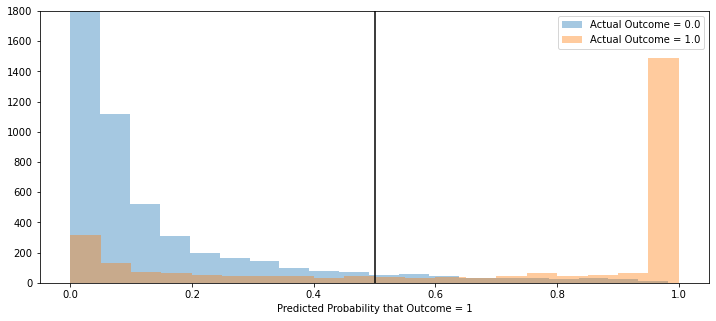

In [188]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred9_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 1800);

In [ ]:
dc.metrics.roc_auc_score

In [191]:
print('Test set score:', model9.evaluate(test_dataset, dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode='classification')))

Test set score: {'mean-roc_auc_score': 0.9008084814746785}


In [197]:

# from sklearn import metrics


# y = np.array([1, 1, 2, 2])
# pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(valid_dataset.y.flatten(), np.array([x[1] for x in pred9]))
auc(fpr, tpr)


0.9057449557399426

In [ ]:
RocCurveDisplay()

#### model 10

In [199]:
save_dir10=f'{get_home_path()}/models/gcn_model_10/callbacks'

model10 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[1024, 512],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_10')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir10,
                                        save_on_minimum=False)
hist10 = model10.fit(train_dataset, nb_epoch=20, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_12/Reshape_14:0", shape=(552,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_12/Reshape_13:0", shape=(552, 512), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_12/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_12/Reshape_17:0", shape=(3260,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_mo

Step 1000 validation: mean-matthews_corrcoef=0.0749301 mean-accuracy_score=0.955354 mean-roc_auc_score=0.823519
Step 2000 validation: mean-matthews_corrcoef=0.0841959 mean-accuracy_score=0.955191 mean-roc_auc_score=0.825633
Step 3000 validation: mean-matthews_corrcoef=0.222645 mean-accuracy_score=0.956853 mean-roc_auc_score=0.855938
Step 4000 validation: mean-matthews_corrcoef=0.0870839 mean-accuracy_score=0.95555 mean-roc_auc_score=0.854983
Step 5000 validation: mean-matthews_corrcoef=0.313674 mean-accuracy_score=0.952519 mean-roc_auc_score=0.853513
Step 6000 validation: mean-matthews_corrcoef=0.2556 mean-accuracy_score=0.957831 mean-roc_auc_score=0.872088
Step 7000 validation: mean-matthews_corrcoef=0.276459 mean-accuracy_score=0.957831 mean-roc_auc_score=0.863173
Step 8000 validation: mean-matthews_corrcoef=0.223942 mean-accuracy_score=0.957505 mean-roc_auc_score=0.876804
Step 9000 validation: mean-matthews_corrcoef=0.311143 mean-accuracy_score=0.958092 mean-roc_auc_score=0.871792
S

In [200]:
evaluate_model(model10, hist10, save_dir10)

Training set score: {'mean-matthews_corrcoef': 0.6335385781975322, 'mean-accuracy_score': 0.9702923109510697, 'mean-roc_auc_score': 0.961515084775735}
Validation set score: {'mean-matthews_corrcoef': 0.4787927575103589, 'mean-accuracy_score': 0.9584501075408981, 'mean-roc_auc_score': 0.9025637020453146}
Test set score: {'mean-matthews_corrcoef': 0.45549041923086453, 'mean-accuracy_score': 0.9574412617720859, 'mean-roc_auc_score': 0.8991438760820261}
Best validation set score: {'mean-matthews_corrcoef': 0.47967790456375287, 'mean-accuracy_score': 0.9603728084468487, 'mean-roc_auc_score': 0.9118796090983995}
Loss? = 0.09841734568277995
[[28875   437]
 [  779   595]]
Specificity = 0.9851
FPR = 0.0149
Recall/TPR = 0.433
Precision = 0.5766


In [201]:
pred10 = [x.flatten() for x in model10.predict(valid_dataset)]

In [202]:

pred10_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred10])})

pred10_df.head()

,true_values,pred_probs
0,1.0,0.014788
1,0.0,0.001358
2,0.0,0.015869
3,0.0,0.001218
4,0.0,0.000029


In [41]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred10_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 2000);

NameError: name 'pred10_df' is not defined

<Figure size 864x360 with 0 Axes>

#### model 11

In [21]:
save_dir11=f'{get_home_path()}/models/gcn_model_11/callbacks'

model11 = GraphConvModel(1, batch_size=128,
                        dropout=0.0,
                        graph_conv_layers=[512, 1024],
                        dense_layer_size=256,
                        mode='classification',
                        model_dir=f'{get_home_path()}/models/gcn_model_11')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir11,
                                        save_on_minimum=False)

In [21]:
hist11 = model11.fit(train_dataset, nb_epoch=200, callbacks=validation)

2022-05-14 11:57:57.064529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 11:57:57.067045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 11:57:57.067880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 11:57:57.068484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Step 1000 validation: mean-matthews_corrcoef=0.12553 mean-accuracy_score=0.95555 mean-roc_auc_score=0.82594
Step 2000 validation: mean-matthews_corrcoef=0.259122 mean-accuracy_score=0.956234 mean-roc_auc_score=0.838415
Step 3000 validation: mean-matthews_corrcoef=0.322674 mean-accuracy_score=0.954865 mean-roc_auc_score=0.848688
Step 4000 validation: mean-matthews_corrcoef=0.210909 mean-accuracy_score=0.956886 mean-roc_auc_score=0.853348
Step 5000 validation: mean-matthews_corrcoef=0.282432 mean-accuracy_score=0.957244 mean-roc_auc_score=0.853595
Step 6000 validation: mean-matthews_corrcoef=0.227346 mean-accuracy_score=0.956723 mean-roc_auc_score=0.857647
Step 7000 validation: mean-matthews_corrcoef=0.341555 mean-accuracy_score=0.957701 mean-roc_auc_score=0.870065
Step 8000 validation: mean-matthews_corrcoef=0.30998 mean-accuracy_score=0.957864 mean-roc_auc_score=0.868527
Step 9000 validation: mean-matthews_corrcoef=0.313041 mean-accuracy_score=0.959037 mean-roc_auc_score=0.87669
Step 1

In [22]:
evaluate_model(model11, hist11, save_dir11)

Training set score: {'mean-matthews_corrcoef': 0.9886646777979844, 'mean-accuracy_score': 0.9990305183060955, 'mean-roc_auc_score': 0.9999464164108443}
Validation set score: {'mean-matthews_corrcoef': 0.47246252561496016, 'mean-accuracy_score': 0.9592322231636577, 'mean-roc_auc_score': 0.8847153576956326}
Test set score: {'mean-matthews_corrcoef': 0.45208120822716674, 'mean-accuracy_score': 0.9575390230390719, 'mean-roc_auc_score': 0.8811270699702469}
Best validation set score: {'mean-matthews_corrcoef': 0.5072253130749046, 'mean-accuracy_score': 0.9620999804471094, 'mean-roc_auc_score': 0.9022784670609987}
Loss? = 0.005859992504119873
[[28888   424]
 [  739   635]]
Specificity = 0.9855
FPR = 0.0145
Recall/TPR = 0.4622
Precision = 0.5996


In [25]:
pred11 = [x.flatten() for x in model11.predict(valid_dataset)]

In [26]:

pred11_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred11])})

pred11_df.head()

,true_values,pred_probs
0,0.0,0.000401
1,0.0,0.000221
2,0.0,0.001008
3,0.0,0.000019
4,0.0,0.461923


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


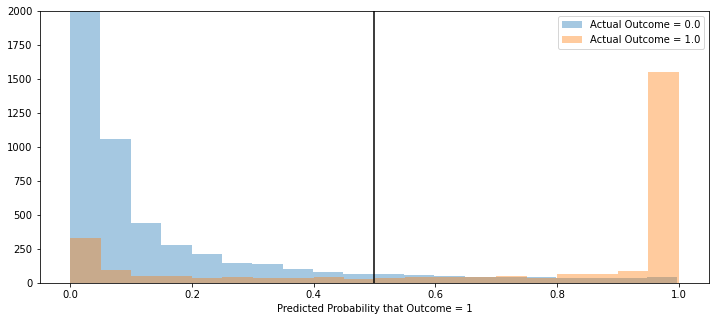

In [40]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred11_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 2000);

#### model 12

In [31]:
save_dir12=f'{get_home_path()}/models/gcn_model_12/callbacks'

model12 = GraphConvModel(1, batch_size=128,
                         dropout=0.4,
                         graph_conv_layers=[512, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         model_dir=f'{get_home_path()}/models/gcn_model_12')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir12,
                                        save_on_minimum=False)

hist12 = model12.fit(train_dataset, nb_epoch=100, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_14:0", shape=(539,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_13:0", shape=(539, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_3/graph_pool_7/Reshape_17:0", shape=(3500,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model

Step 1000 validation: mean-matthews_corrcoef=0.174233 mean-accuracy_score=0.847422 mean-roc_auc_score=0.737251
Step 2000 validation: mean-matthews_corrcoef=0.0997615 mean-accuracy_score=0.638891 mean-roc_auc_score=0.673467
Step 3000 validation: mean-matthews_corrcoef=0.0672155 mean-accuracy_score=0.365932 mean-roc_auc_score=0.656573
Step 4000 validation: mean-matthews_corrcoef=0.0637507 mean-accuracy_score=0.270449 mean-roc_auc_score=0.688401
Step 5000 validation: mean-matthews_corrcoef=0.0748139 mean-accuracy_score=0.512416 mean-roc_auc_score=0.677161
Step 6000 validation: mean-matthews_corrcoef=0.0559193 mean-accuracy_score=0.362315 mean-roc_auc_score=0.672145
Step 7000 validation: mean-matthews_corrcoef=0.0695083 mean-accuracy_score=0.401062 mean-roc_auc_score=0.630751
Step 8000 validation: mean-matthews_corrcoef=0.195316 mean-accuracy_score=0.759369 mean-roc_auc_score=0.773623
Step 9000 validation: mean-matthews_corrcoef=0.069914 mean-accuracy_score=0.378511 mean-roc_auc_score=0.65

KeyboardInterrupt: 

In [32]:
evaluate_model(model12, hist12, save_dir12)

NameError: name 'hist12' is not defined

#### model 13

In [33]:
save_dir13=f'{get_home_path()}/models/gcn_model_13/callbacks'

model13 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[64, 256, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         model_dir=f'{get_home_path()}/models/gcn_model_13')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir13,
                                        save_on_minimum=False)

hist13 = model13.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_14:0", shape=(580,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_13:0", shape=(580, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_10/Reshape_17:0", shape=(3312,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_m

Step 1000 validation: mean-matthews_corrcoef=0.108458 mean-accuracy_score=0.95555 mean-roc_auc_score=0.817729
Step 2000 validation: mean-matthews_corrcoef=0.148704 mean-accuracy_score=0.95581 mean-roc_auc_score=0.839141
Step 3000 validation: mean-matthews_corrcoef=0.250886 mean-accuracy_score=0.957179 mean-roc_auc_score=0.857552
Step 4000 validation: mean-matthews_corrcoef=0.209686 mean-accuracy_score=0.956984 mean-roc_auc_score=0.863411
Step 5000 validation: mean-matthews_corrcoef=0.284893 mean-accuracy_score=0.957896 mean-roc_auc_score=0.859309
Step 6000 validation: mean-matthews_corrcoef=0.234004 mean-accuracy_score=0.957179 mean-roc_auc_score=0.869292
Step 7000 validation: mean-matthews_corrcoef=0.284201 mean-accuracy_score=0.95845 mean-roc_auc_score=0.870584
Step 8000 validation: mean-matthews_corrcoef=0.368751 mean-accuracy_score=0.959688 mean-roc_auc_score=0.872785
Step 9000 validation: mean-matthews_corrcoef=0.296611 mean-accuracy_score=0.959102 mean-roc_auc_score=0.875513
Step

In [35]:
evaluate_model(model13, hist13, save_dir13)

Training set score: {'mean-matthews_corrcoef': 0.909140121876442, 'mean-accuracy_score': 0.9923948641910938, 'mean-roc_auc_score': 0.998363235694375}
Validation set score: {'mean-matthews_corrcoef': 0.4833174530782624, 'mean-accuracy_score': 0.9604379847487453, 'mean-roc_auc_score': 0.8920752781498891}
Test set score: {'mean-matthews_corrcoef': 0.4723276007506134, 'mean-accuracy_score': 0.9602437514256852, 'mean-roc_auc_score': 0.8915162808121608}
Best validation set score: {'mean-matthews_corrcoef': 0.5157338258031209, 'mean-accuracy_score': 0.9591018705598644, 'mean-roc_auc_score': 0.9039374184599518}
Loss? = 0.024915108680725096
[[28703   609]
 [  646   728]]
Specificity = 0.9792
FPR = 0.0208
Recall/TPR = 0.5298
Precision = 0.5445


In [36]:
pred13 = [x.flatten() for x in model13.predict(valid_dataset)]

In [37]:

pred13_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred13])})

pred13_df.head()

,true_values,pred_probs
0,0.0,0.007747
1,0.0,0.008081
2,0.0,0.000207
3,0.0,0.000060
4,0.0,0.594337


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


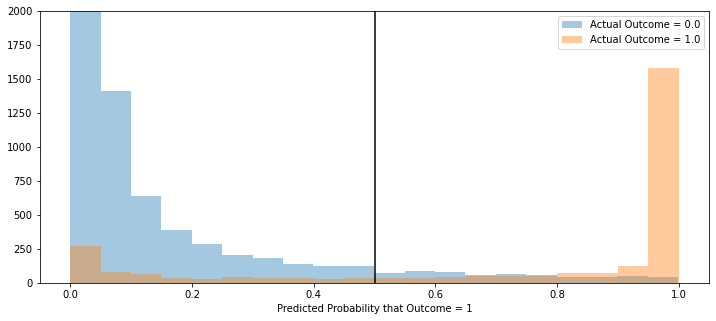

In [39]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred13_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 2000);

#### model 14

In [44]:
save_dir14=f'{get_home_path()}/models/gcn_model_14/callbacks'

model14 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[64, 128, 256, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         model_dir=f'{get_home_path()}/models/gcn_model_14')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir14,
                                        save_on_minimum=False)

hist14 = model14.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_14:0", shape=(538,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_13:0", shape=(538, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_17:0", shape=(3182,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_m

Step 1000 validation: mean-matthews_corrcoef=0.112536 mean-accuracy_score=0.955224 mean-roc_auc_score=0.822666
Step 2000 validation: mean-matthews_corrcoef=0.176622 mean-accuracy_score=0.955778 mean-roc_auc_score=0.836623
Step 3000 validation: mean-matthews_corrcoef=0.134022 mean-accuracy_score=0.955713 mean-roc_auc_score=0.846425
Step 4000 validation: mean-matthews_corrcoef=0.259415 mean-accuracy_score=0.957049 mean-roc_auc_score=0.858792
Step 5000 validation: mean-matthews_corrcoef=0.344481 mean-accuracy_score=0.95555 mean-roc_auc_score=0.8618
Step 6000 validation: mean-matthews_corrcoef=0.290977 mean-accuracy_score=0.957538 mean-roc_auc_score=0.86468
Step 7000 validation: mean-matthews_corrcoef=0.260783 mean-accuracy_score=0.957407 mean-roc_auc_score=0.866574
Step 8000 validation: mean-matthews_corrcoef=0.319455 mean-accuracy_score=0.959134 mean-roc_auc_score=0.871015
Step 9000 validation: mean-matthews_corrcoef=0.355358 mean-accuracy_score=0.95933 mean-roc_auc_score=0.878626
Step 1

In [45]:
evaluate_model(model14, hist14, save_dir14)

Training set score: {'mean-matthews_corrcoef': 0.9070435223658783, 'mean-accuracy_score': 0.992325615498672, 'mean-roc_auc_score': 0.9984876464016141}
Validation set score: {'mean-matthews_corrcoef': 0.47465749458314266, 'mean-accuracy_score': 0.9614808055790914, 'mean-roc_auc_score': 0.8894597581984992}
Test set score: {'mean-matthews_corrcoef': 0.44472971937887906, 'mean-accuracy_score': 0.9596245967347736, 'mean-roc_auc_score': 0.8910045500476188}
Best validation set score: {'mean-matthews_corrcoef': 0.5090293891953639, 'mean-accuracy_score': 0.9603402202959004, 'mean-roc_auc_score': 0.9029619360428067}
Loss? = 0.024895613193511964
[[28787   525]
 [  692   682]]
Specificity = 0.9821
FPR = 0.0179
Recall/TPR = 0.4964
Precision = 0.565


In [46]:
pred14 = [x.flatten() for x in model14.predict(valid_dataset)]

In [48]:

pred14_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred14])})

pred14_df.head()

,true_values,pred_probs
0,0.0,1.075752e-04
1,0.0,6.326331e-07
2,0.0,1.694275e-09
3,0.0,9.569930e-06
4,0.0,3.442868e-01


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


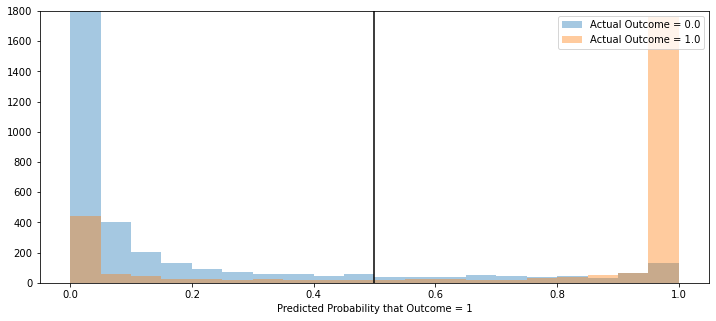

In [49]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred14_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 1800);

In [53]:
dir(model14.optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_create_jax_optimizer',
 '_create_pytorch_optimizer',
 '_create_tf_optimizer',
 'beta1',
 'beta2',
 'epsilon',
 'learning_rate']

In [54]:
dir(model14)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_built',
 '_checkpoint',
 '_compute_model',
 '_create_assignment_map',
 '_create_gradient_fn',
 '_create_inputs',
 '_create_training_ops',
 '_create_value_map',
 '_ensure_built',
 '_global_step',
 '_gradient_fn_for_vars',
 '_input_dtypes',
 '_input_shapes',
 '_inputs_built',
 '_label_dtypes',
 '_log_scalar_to_tensorboard',
 '_loss_fn',
 '_loss_outputs',
 '_other_outputs',
 '_output_functions',
 '_predict',
 '_prediction_outputs',
 '_prepare_batch',
 '_summary_writer',
 '_tf_optimizer',
 '_training_ops_built',
 '_variance_outputs',
 '_weights_dtypes',
 'batch_size',
 'compute_saliency',
 'default_generator',
 

In [69]:
hist14

0.024895613193511964

In [63]:
print(model14.learning_rate)

1


In [64]:
hist14_2 = model14.fit(train_dataset, nb_epoch=50, callbacks=validation)

Step 103000 validation: mean-matthews_corrcoef=0.485382 mean-accuracy_score=0.961546 mean-roc_auc_score=0.893409
Step 104000 validation: mean-matthews_corrcoef=0.499456 mean-accuracy_score=0.961513 mean-roc_auc_score=0.896373
Step 105000 validation: mean-matthews_corrcoef=0.480187 mean-accuracy_score=0.959363 mean-roc_auc_score=0.89578
Step 106000 validation: mean-matthews_corrcoef=0.492008 mean-accuracy_score=0.958874 mean-roc_auc_score=0.896586
Step 107000 validation: mean-matthews_corrcoef=0.483853 mean-accuracy_score=0.961904 mean-roc_auc_score=0.895791


KeyboardInterrupt: 

In [44]:
save_dir14=f'{get_home_path()}/models/gcn_model_14/callbacks'

model14 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[64, 128, 256, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         model_dir=f'{get_home_path()}/models/gcn_model_14')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=save_dir14,
                                        save_on_minimum=False)

hist14 = model14.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_14:0", shape=(538,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_13:0", shape=(538, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_5/graph_pool_14/Reshape_17:0", shape=(3182,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_m

Step 1000 validation: mean-matthews_corrcoef=0.112536 mean-accuracy_score=0.955224 mean-roc_auc_score=0.822666
Step 2000 validation: mean-matthews_corrcoef=0.176622 mean-accuracy_score=0.955778 mean-roc_auc_score=0.836623
Step 3000 validation: mean-matthews_corrcoef=0.134022 mean-accuracy_score=0.955713 mean-roc_auc_score=0.846425
Step 4000 validation: mean-matthews_corrcoef=0.259415 mean-accuracy_score=0.957049 mean-roc_auc_score=0.858792
Step 5000 validation: mean-matthews_corrcoef=0.344481 mean-accuracy_score=0.95555 mean-roc_auc_score=0.8618
Step 6000 validation: mean-matthews_corrcoef=0.290977 mean-accuracy_score=0.957538 mean-roc_auc_score=0.86468
Step 7000 validation: mean-matthews_corrcoef=0.260783 mean-accuracy_score=0.957407 mean-roc_auc_score=0.866574
Step 8000 validation: mean-matthews_corrcoef=0.319455 mean-accuracy_score=0.959134 mean-roc_auc_score=0.871015
Step 9000 validation: mean-matthews_corrcoef=0.355358 mean-accuracy_score=0.95933 mean-roc_auc_score=0.878626
Step 1

In [45]:
evaluate_model(model14, hist14, save_dir14)

Training set score: {'mean-matthews_corrcoef': 0.9070435223658783, 'mean-accuracy_score': 0.992325615498672, 'mean-roc_auc_score': 0.9984876464016141}
Validation set score: {'mean-matthews_corrcoef': 0.47465749458314266, 'mean-accuracy_score': 0.9614808055790914, 'mean-roc_auc_score': 0.8894597581984992}
Test set score: {'mean-matthews_corrcoef': 0.44472971937887906, 'mean-accuracy_score': 0.9596245967347736, 'mean-roc_auc_score': 0.8910045500476188}
Best validation set score: {'mean-matthews_corrcoef': 0.5090293891953639, 'mean-accuracy_score': 0.9603402202959004, 'mean-roc_auc_score': 0.9029619360428067}
Loss? = 0.024895613193511964
[[28787   525]
 [  692   682]]
Specificity = 0.9821
FPR = 0.0179
Recall/TPR = 0.4964
Precision = 0.565


In [70]:
pred14 = [x.flatten() for x in model14.predict(valid_dataset)]

In [71]:

pred14_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred14])})

pred14_df.head()

,true_values,pred_probs
0,0.0,1.421059e-05
1,0.0,1.249137e-05
2,0.0,9.676490e-11
3,0.0,3.366851e-05
4,0.0,2.216783e-02


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


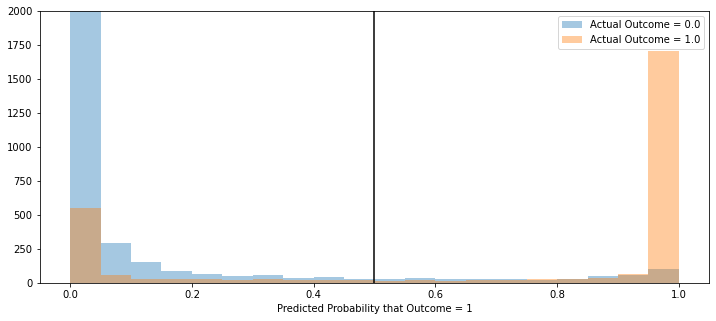

In [72]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred14_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 2000);

#### model 15

In [98]:
validation.output_file

In [100]:
learning_rate15 = dc.models.optimizers.ExponentialDecay(0.0002, 0.9, 1000)
save_dir15=f'{get_home_path()}/models/gcn_model_15'

model15 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[512, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate15,
                         model_dir=save_dir15)
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=f'{save_dir15}/callbacks',
                                        save_on_minimum=False)

In [103]:
model15.loss

In [110]:
hist15 = model15.fit(train_dataset, nb_epoch=20, callbacks=validation, restore=True)

Step 96000 validation: mean-matthews_corrcoef=0.484291 mean-accuracy_score=0.9621 mean-roc_auc_score=0.901314
Step 97000 validation: mean-matthews_corrcoef=0.487451 mean-accuracy_score=0.960308 mean-roc_auc_score=0.897593
Step 98000 validation: mean-matthews_corrcoef=0.463609 mean-accuracy_score=0.962165 mean-roc_auc_score=0.897568
Step 99000 validation: mean-matthews_corrcoef=0.465393 mean-accuracy_score=0.95379 mean-roc_auc_score=0.893987
Step 100000 validation: mean-matthews_corrcoef=0.470255 mean-accuracy_score=0.959363 mean-roc_auc_score=0.894683
Step 101000 validation: mean-matthews_corrcoef=0.468864 mean-accuracy_score=0.961025 mean-roc_auc_score=0.898388
Step 102000 validation: mean-matthews_corrcoef=0.486793 mean-accuracy_score=0.960992 mean-roc_auc_score=0.90297
Step 103000 validation: mean-matthews_corrcoef=0.477504 mean-accuracy_score=0.961904 mean-roc_auc_score=0.899286
Step 104000 validation: mean-matthews_corrcoef=0.489524 mean-accuracy_score=0.961481 mean-roc_auc_score=

In [111]:
evaluate_model(model15, hist15, save_dir15)

Training set score: {'mean-matthews_corrcoef': 0.9207555725826339, 'mean-accuracy_score': 0.9931443794502468, 'mean-roc_auc_score': 0.9987767954381437}
Validation set score: {'mean-matthews_corrcoef': 0.49751482292778093, 'mean-accuracy_score': 0.9596884572769341, 'mean-roc_auc_score': 0.9024850732549436}
Test set score: {'mean-matthews_corrcoef': 0.4706869427390173, 'mean-accuracy_score': 0.9575064359500766, 'mean-roc_auc_score': 0.8960391845161029}
Best validation set score: {'mean-matthews_corrcoef': 0.4743725453287934, 'mean-accuracy_score': 0.957928697125725, 'mean-roc_auc_score': 0.8933988700297318}
Loss? = 0.032622498273849485
[[28763   549]
 [  742   632]]
Specificity = 0.9813
FPR = 0.0187
Recall/TPR = 0.46
Precision = 0.5351


In [107]:
pred15 = [x.flatten() for x in model15.predict(valid_dataset)]

In [108]:

pred15_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred15])})

pred15_df.head()

,true_values,pred_probs
0,0.0,0.000171
1,0.0,0.001512
2,0.0,0.000003
3,0.0,0.000036
4,0.0,0.957680


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


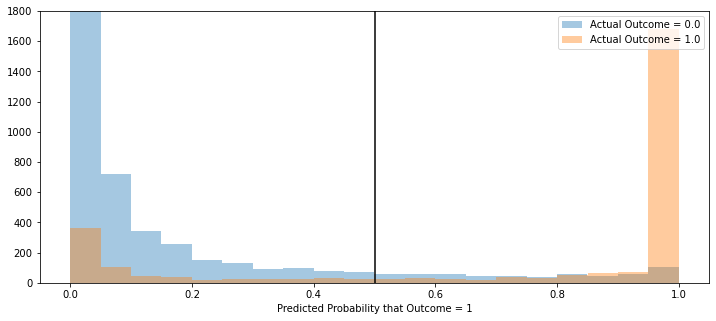

In [109]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred15_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend()
plt.ylim(0, 1800);

#### model 16

In [98]:
validation.output_file

In [117]:
learning_rate16 = dc.models.optimizers.ExponentialDecay(0.001, 0.8, 1024)
save_dir16=f'{get_home_path()}/models/gcn_model_16'

model16 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[512, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate16,
                         model_dir=save_dir16)
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir16}/callbacks',
                                        save_on_minimum=False)

In [119]:
hist16 = model16.fit(train_dataset, nb_epoch=50, callbacks=validation)

Step 1024 validation: mean-matthews_corrcoef=0.156412 mean-accuracy_score=0.955582 mean-roc_auc_score=0.816538
Step 2048 validation: mean-matthews_corrcoef=0.105623 mean-accuracy_score=0.955582 mean-roc_auc_score=0.834675
Step 3072 validation: mean-matthews_corrcoef=0.24998 mean-accuracy_score=0.95744 mean-roc_auc_score=0.854413
Step 4096 validation: mean-matthews_corrcoef=0.244386 mean-accuracy_score=0.957635 mean-roc_auc_score=0.856114
Step 5120 validation: mean-matthews_corrcoef=0.313417 mean-accuracy_score=0.954931 mean-roc_auc_score=0.86222
Step 6144 validation: mean-matthews_corrcoef=0.195532 mean-accuracy_score=0.956886 mean-roc_auc_score=0.861114
Step 7168 validation: mean-matthews_corrcoef=0.360814 mean-accuracy_score=0.958646 mean-roc_auc_score=0.872346
Step 8192 validation: mean-matthews_corrcoef=0.243736 mean-accuracy_score=0.957798 mean-roc_auc_score=0.871646
Step 9216 validation: mean-matthews_corrcoef=0.289651 mean-accuracy_score=0.958711 mean-roc_auc_score=0.874031
Step

In [122]:
evaluate_model(model16, hist16, save_dir16)

Training set score: {'mean-matthews_corrcoef': 0.8927756751796663, 'mean-accuracy_score': 0.9908632460528245, 'mean-roc_auc_score': 0.9976606794241611}
Validation set score: {'mean-matthews_corrcoef': 0.48610187283927797, 'mean-accuracy_score': 0.959167046861761, 'mean-roc_auc_score': 0.894108869322588}
Test set score: {'mean-matthews_corrcoef': 0.4625984316111824, 'mean-accuracy_score': 0.9567569329031838, 'mean-roc_auc_score': 0.8956954195273609}
Best validation set score: {'mean-matthews_corrcoef': 0.4976525550546536, 'mean-accuracy_score': 0.9589389298051229, 'mean-roc_auc_score': 0.9024744400254572}
Loss? = 0.03420705506295869
[[28748   564]
 [  696   678]]
Specificity = 0.9808
FPR = 0.0192
Recall/TPR = 0.4934
Precision = 0.5459


#### model 17

In [127]:
learning_rate17 = dc.models.optimizers.ExponentialDecay(0.0001, 0.8, 1024)
save_dir17=f'{get_home_path()}/models/gcn_model_17'

model17 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[512, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate17,
                         model_dir=save_dir17)
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir17}/callbacks',
                                        save_on_minimum=False)

In [128]:
hist17 = model17.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_16/graph_pool_36/Reshape_14:0", shape=(528,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_16/graph_pool_36/Reshape_13:0", shape=(528, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_16/graph_pool_36/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_16/graph_pool_36/Reshape_17:0", shape=(3236,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_ker

Step 1024 validation: mean-matthews_corrcoef=0.204588 mean-accuracy_score=0.956593 mean-roc_auc_score=0.838298
Step 2048 validation: mean-matthews_corrcoef=0.153404 mean-accuracy_score=0.956006 mean-roc_auc_score=0.849612
Step 3072 validation: mean-matthews_corrcoef=0.221073 mean-accuracy_score=0.956299 mean-roc_auc_score=0.856705
Step 4096 validation: mean-matthews_corrcoef=0.174981 mean-accuracy_score=0.956136 mean-roc_auc_score=0.861479
Step 5120 validation: mean-matthews_corrcoef=0.302515 mean-accuracy_score=0.956821 mean-roc_auc_score=0.864502
Step 6144 validation: mean-matthews_corrcoef=0.229166 mean-accuracy_score=0.957407 mean-roc_auc_score=0.868504
Step 7168 validation: mean-matthews_corrcoef=0.322477 mean-accuracy_score=0.958711 mean-roc_auc_score=0.881476
Step 8192 validation: mean-matthews_corrcoef=0.324755 mean-accuracy_score=0.958678 mean-roc_auc_score=0.880466
Step 9216 validation: mean-matthews_corrcoef=0.266704 mean-accuracy_score=0.958189 mean-roc_auc_score=0.879405
S

In [129]:
evaluate_model(model17, hist17, save_dir17)

Training set score: {'mean-matthews_corrcoef': 0.8483985164161991, 'mean-accuracy_score': 0.9876044840565069, 'mean-roc_auc_score': 0.995549869080302}
Validation set score: {'mean-matthews_corrcoef': 0.49007610781698174, 'mean-accuracy_score': 0.961545981880988, 'mean-roc_auc_score': 0.8972737293458364}
Test set score: {'mean-matthews_corrcoef': 0.47299340720365723, 'mean-accuracy_score': 0.9608629061165966, 'mean-roc_auc_score': 0.8971972421236217}
Best validation set score: {'mean-matthews_corrcoef': 0.5054448195412395, 'mean-accuracy_score': 0.9630450368246106, 'mean-roc_auc_score': 0.9066868066116365}
Loss? = 0.042947678565979
[[28948   364]
 [  770   604]]
Specificity = 0.9876
FPR = 0.0124
Recall/TPR = 0.4396
Precision = 0.624


#### model 18

In [132]:
learning_rate18 = dc.models.optimizers.ExponentialDecay(0.0001, 0.8, 1024)
save_dir18=f'{get_home_path()}/models/gcn_model_18'

model18 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[64, 256, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate18,
                         model_dir=f'{get_home_path()}/models/gcn_model_18')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir18}/callbacks',
                                        save_on_minimum=False)

In [133]:
hist18 = model18.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_17/graph_pool_39/Reshape_14:0", shape=(538,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_17/graph_pool_39/Reshape_13:0", shape=(538, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_17/graph_pool_39/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_17/graph_pool_39/Reshape_17:0", shape=(3470,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_ker

Step 1024 validation: mean-matthews_corrcoef=0.235187 mean-accuracy_score=0.955908 mean-roc_auc_score=0.839541
Step 2048 validation: mean-matthews_corrcoef=0.273997 mean-accuracy_score=0.957049 mean-roc_auc_score=0.860871
Step 3072 validation: mean-matthews_corrcoef=0.279093 mean-accuracy_score=0.957831 mean-roc_auc_score=0.872431
Step 4096 validation: mean-matthews_corrcoef=0.192551 mean-accuracy_score=0.956625 mean-roc_auc_score=0.870914
Step 5120 validation: mean-matthews_corrcoef=0.319881 mean-accuracy_score=0.959134 mean-roc_auc_score=0.879366
Step 6144 validation: mean-matthews_corrcoef=0.338821 mean-accuracy_score=0.959721 mean-roc_auc_score=0.884851
Step 7168 validation: mean-matthews_corrcoef=0.361393 mean-accuracy_score=0.959134 mean-roc_auc_score=0.879515
Step 8192 validation: mean-matthews_corrcoef=0.394698 mean-accuracy_score=0.960992 mean-roc_auc_score=0.88814
Step 9216 validation: mean-matthews_corrcoef=0.394254 mean-accuracy_score=0.960373 mean-roc_auc_score=0.886989
St

In [134]:
evaluate_model(model18, hist18, save_dir18)

Training set score: {'mean-matthews_corrcoef': 0.9336822419012412, 'mean-accuracy_score': 0.9943908559138384, 'mean-roc_auc_score': 0.9991360995012725}
Validation set score: {'mean-matthews_corrcoef': 0.47689518696611505, 'mean-accuracy_score': 0.9596232809750375, 'mean-roc_auc_score': 0.8967864878307685}
Test set score: {'mean-matthews_corrcoef': 0.4639100959675954, 'mean-accuracy_score': 0.959559422556783, 'mean-roc_auc_score': 0.895078024261657}
Best validation set score: {'mean-matthews_corrcoef': 0.5000765849173642, 'mean-accuracy_score': 0.9637945642964219, 'mean-roc_auc_score': 0.9049660484024109}
Loss? = 0.026622450351715087
[[29011   301]
 [  810   564]]
Specificity = 0.9897
FPR = 0.0103
Recall/TPR = 0.4105
Precision = 0.652


#### Model 19

In [ ]:
19. 3 GCN layers (1024, 2048); 1-layer FNN (256); 50 epochs; ExponentialDecay(0.001, 0.7, 1024) learning rate:  
    
    

In [2]:
learning_rate19 = dc.models.optimizers.ExponentialDecay(0.001, 0.7, 1024)
save_dir19=f'{get_home_path()}/models/gcn_model_19'

model19 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[1024, 2048],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate19,
                         model_dir=f'{get_home_path()}/models/gcn_model_19')
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir19}/callbacks',
                                        save_on_minimum=False)

NameError: name 'dc' is not defined

In [ ]:
hist19 = model19.fit(train_dataset, nb_epoch=50, callbacks=validation)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_18/graph_pool_41/Reshape_14:0", shape=(579,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_18/graph_pool_41/Reshape_13:0", shape=(579, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_18/graph_pool_41/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_18/graph_pool_41/Reshape_17:0", shape=(3272,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_ker

Step 1024 validation: mean-matthews_corrcoef=0.146067 mean-accuracy_score=0.955713 mean-roc_auc_score=0.820403
Step 2048 validation: mean-matthews_corrcoef=0.293016 mean-accuracy_score=0.95304 mean-roc_auc_score=0.836766
Step 3072 validation: mean-matthews_corrcoef=0.199936 mean-accuracy_score=0.956951 mean-roc_auc_score=0.846428
Step 4096 validation: mean-matthews_corrcoef=0.148367 mean-accuracy_score=0.954768 mean-roc_auc_score=0.83563
Step 5120 validation: mean-matthews_corrcoef=0.252259 mean-accuracy_score=0.95744 mean-roc_auc_score=0.866396
Step 6144 validation: mean-matthews_corrcoef=0.2774 mean-accuracy_score=0.958026 mean-roc_auc_score=0.860492
Step 7168 validation: mean-matthews_corrcoef=0.305461 mean-accuracy_score=0.958809 mean-roc_auc_score=0.855304
Step 8192 validation: mean-matthews_corrcoef=0.326763 mean-accuracy_score=0.959134 mean-roc_auc_score=0.871506
Step 9216 validation: mean-matthews_corrcoef=0.296153 mean-accuracy_score=0.958841 mean-roc_auc_score=0.868155
Step 1

In [1]:
hist19 = model19.fit(train_dataset, nb_epoch=5, callbacks=validation, restore=True)

NameError: name 'model19' is not defined

In [ ]:
evaluate_model(model19, hist19, save_dir19)

## Best model (# 13)


In [ ]:
learning_rate17 = dc.models.optimizers.ExponentialDecay(0.0001, 0.8, 1024)
save_dir17=f'{get_home_path()}/models/gcn_model_17'

model17 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[512, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         learning_rate=learning_rate17,
                         model_dir=save_dir17)
validation=dc.models.ValidationCallback(valid_dataset,
                                        1024,
                                        metrics,
                                        save_dir=f'{save_dir17}/callbacks',
                                        save_on_minimum=False)

In [37]:
save_dir13=f'{get_home_path()}/models/gcn_model_13'

model13 = GraphConvModel(1, batch_size=128,
                         dropout=0.0,
                         graph_conv_layers=[64, 256, 1024],
                         dense_layer_size=256,
                         mode='classification',
                         tensorboard=True,
                         model_dir=save_dir13)
validation=dc.models.ValidationCallback(valid_dataset,
                                        1000,
                                        metrics,
                                        save_dir=f'{save_dir13}/callbacks',
                                        save_on_minimum=False)

# hist13 = model13.fit(train_dataset, nb_epoch=50, callbacks=validation)

2022-07-21 01:23:39.118488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
hist13_best = model13.fit(train_dataset, nb_epoch=5, callbacks=validation, restore=True)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_14:0", shape=(554,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_13:0", shape=(554, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_17:0", shape=(3272,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_p

Step 1000 validation: mean-matthews_corrcoef=0.772512 mean-accuracy_score=0.98149 mean-roc_auc_score=0.975982
Step 2000 validation: mean-matthews_corrcoef=0.762117 mean-accuracy_score=0.979665 mean-roc_auc_score=0.97507
Step 3000 validation: mean-matthews_corrcoef=0.751655 mean-accuracy_score=0.979893 mean-roc_auc_score=0.974703
Step 4000 validation: mean-matthews_corrcoef=0.747432 mean-accuracy_score=0.980154 mean-roc_auc_score=0.97714
Step 5000 validation: mean-matthews_corrcoef=0.739306 mean-accuracy_score=0.978459 mean-roc_auc_score=0.975169
Step 6000 validation: mean-matthews_corrcoef=0.738351 mean-accuracy_score=0.978394 mean-roc_auc_score=0.975594
Step 7000 validation: mean-matthews_corrcoef=0.73096 mean-accuracy_score=0.978003 mean-roc_auc_score=0.973294
Step 8000 validation: mean-matthews_corrcoef=0.723854 mean-accuracy_score=0.976667 mean-roc_auc_score=0.9737
Step 9000 validation: mean-matthews_corrcoef=0.712892 mean-accuracy_score=0.976374 mean-roc_auc_score=0.97198


In [39]:
evaluate_model(model13, hist13_best, save_dir13)

Training set score: {'mean-matthews_corrcoef': 0.8825508832528524, 'mean-accuracy_score': 0.9903581379433953, 'mean-roc_auc_score': 0.9971828569919132}
Validation set score: {'mean-matthews_corrcoef': 0.7016626595445933, 'mean-accuracy_score': 0.9764061787134198, 'mean-roc_auc_score': 0.9717915629787126}
Test set score: {'mean-matthews_corrcoef': 0.6971947796427883, 'mean-accuracy_score': 0.9764721217453645, 'mean-roc_auc_score': 0.96960797085872}
Best validation set score: {'mean-matthews_corrcoef': 0.7725118931351501, 'mean-accuracy_score': 0.981489930261357, 'mean-roc_auc_score': 0.9759823837741461}
Loss? = 0.03768966727786594
[[29108   204]
 [  364  1010]]
Specificity = 0.993
FPR = 0.007
Recall/TPR = 0.7351
Precision = 0.832


In [48]:
model13.predict(valid_dataset)

array([[[9.5111984e-01, 4.8880164e-02]],

       [[1.0000000e+00, 4.7359467e-11]],

       [[1.0000000e+00, 7.4841120e-09]],

       ...,

       [[9.9971813e-01, 2.8183195e-04]],

       [[9.9991405e-01, 8.5994427e-05]],

       [[9.8682678e-01, 1.3173239e-02]]], dtype=float32)

In [40]:
pred13 = [x.flatten() for x in model13.predict(valid_dataset)]

In [41]:

pred13_df = pd.DataFrame({'true_values': valid_dataset.y.flatten(),
                        'pred_probs': np.array([x[1] for x in pred13])})

pred13_df.head()

,true_values,pred_probs
0,0.0,4.888016e-02
1,0.0,4.735947e-11
2,0.0,7.484112e-09
3,0.0,1.485819e-05
4,0.0,1.288217e-02


/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


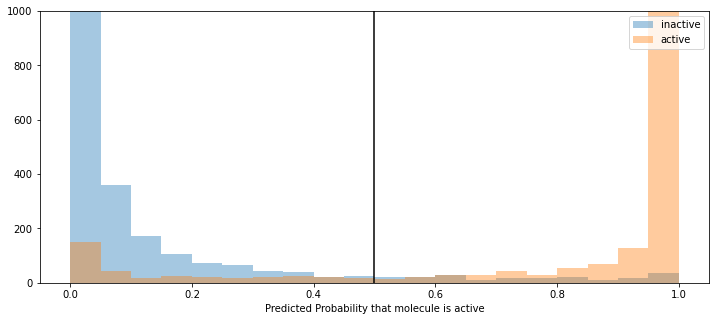

In [56]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred13_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

#Add cutoff line
plt.axvline(0.5, color = 'black')

plt.xlabel('Predicted Probability that molecule is active')
plt.legend(labels=herg_df.label.unique())
plt.ylim(0, 1000);

In [43]:
cm = confusion_matrix(valid_dataset.y, [round(x[1]) for x in pred13])
print(cm)

[[29108   204]
 [  364  1010]]


In [57]:
tn, fp, fn, tp = cm.ravel()

# specificity
print(f'Specificity = {round(tn/(tn+fp), 4)}')

# 1- specificity
print(f'FPR = {round(fp/(tn+fp), 4)}')

# sensitivity
print(f'Recall/TPR = {round(tp/(tp+fn), 4)}')

print(f'Precision = {round(tp/(tp+fp), 4)}')

Specificity = 0.993
FPR = 0.007
Recall/TPR = 0.7351
Precision = 0.832


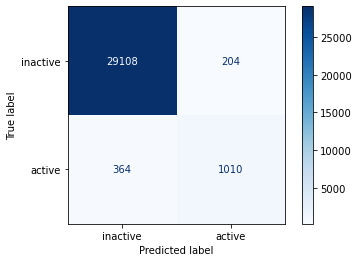

In [99]:
ConfusionMatrixDisplay(cm, display_labels=herg_df.label.unique()).plot(cmap=plt.cm.Blues)

In [59]:
valid_dataset.y.shape


(30686, 1)

In [80]:
np.array([x for x in np.array(pred13)]).shape

(30686, 2)

In [77]:
np.array([x.flatten() for x in np.array(pred13)]).shape

(30686, 2)

In [58]:
RocCurveDisplay.from_predictions(valid_dataset.y, pred13)

ValueError: y should be a 1d array, got an array of shape (30686, 2) instead.

In [ ]:
RocCurveDisplay(round(fp/(tn+fp), 4), round(tp/(tp+fn), 4), dc.metrics.roc_auc_score, np.mean, mode='classification') )

In [81]:
classification_report(valid_dataset.y, pred13)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [82]:
pred13_df2 = pd.DataFrame(pred13,columns=["neg","pos"])

In [83]:
pred13_df2["active"] = [int(x) for x in valid_dataset.y]
pred13_df2["SMILES"] = valid_dataset.ids

In [84]:
pred13_df2.sample(5)

,neg,pos,active,SMILES
10865,1.000000,3.572159e-08,0,COc1cc(C(C)=O)ccc1COc1ccc(C(=O)OCC(=O)NC2CCS(=...
30315,1.000000,2.931368e-09,0,COCC(=O)N1CCC(Oc2ccc(C(=O)N3CCCCC3COC)cc2)CC1
19325,0.999997,2.689592e-06,0,O=C1CCCC(c2ccccc2)N1
1653,0.999999,9.061893e-07,0,CC(=O)c1nn(-c2cccc(C(F)(F)F)c2)c(=O)[nH]c1=O
5793,0.992597,7.403372e-03,0,CCS(=O)(=O)N1Cc2ccccc2CC1C(=O)Nc1nnc(SCc2ccc(C...


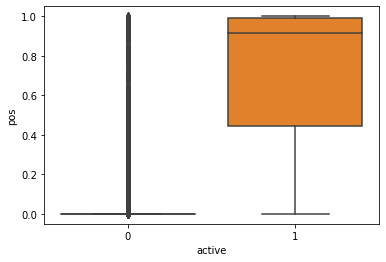

In [85]:
# plot predicted probabilities for active and inactives
sns.boxplot(x=pred13_df2.active, y=pred13_df2.pos);

In [106]:
# put false negatives in a new dataframe
false_negative_df13 = pred13_df2.query("active == 1 & pos < 0.2").copy()
PandasTools.AddMoleculeColumnToFrame(false_negative_df13, 'SMILES', 'Mol')

,pos,active,Mol
1870,0.006739,1,
25659,0.051656,1,
22315,0.178960,1,

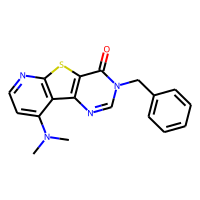
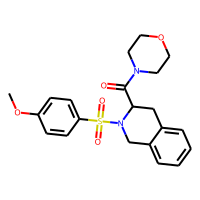
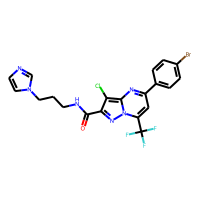

In [111]:
show(false_negative_df13.loc[:, ['pos', 'active', 'Mol']].sample(3))

In [100]:
false_positive_df13 = pred13_df2.query("active == 0 & pos > 0.8").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df13, 'SMILES', 'Mol')

,pos,active,Mol
9364,0.997684,0,
16040,0.986256,0,
9450,0.978238,0,

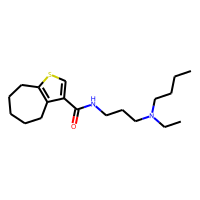
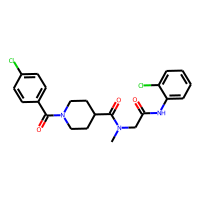
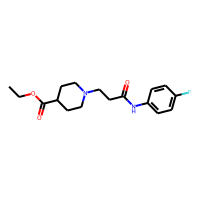

In [109]:
show(false_positive_df13.loc[:, ['pos', 'active', 'Mol']].sample(3))

### explore model results

Previous results (MCC):  
[0.4502412189462288]  
[0.4128819211180105]  
[0.4502412189462288, 0.4965585838893341]  
[0.4128819211180105, 0.4654923820863219]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114, 0.6192709501522672]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515, 0.5214770300289555]  
[0.4502412189462288, 0.4965585838893341, 0.5585299037933114, 0.6192709501522672, 0.5843172323482354]  
[0.4128819211180105, 0.4654923820863219, 0.45430324072314515, 0.5214770300289555, 0.49755690080208853]  

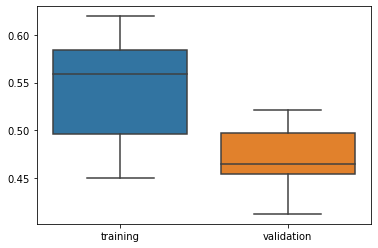

In [ ]:
## training vs validation MCC scores
sns.boxplot(x = ["training"] * cv_folds + ["validation"] * cv_folds, y = training_score_list + validation_score_list);

In [ ]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [ ]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

In [ ]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [ ]:
pred_df.sample(5)

,neg,pos,active,SMILES
10191,0.998757,0.001243,0,CC1=C(C(=O)OCc2ccccc2)C(c2cccnc2)n2ncnc2N1
2610,0.999847,0.000153,0,CN(Cc1cccs1)C(=O)CNC(=O)c1ccco1
3003,0.952261,0.047739,1,N#C/C(=C\c1cccc([N+](=O)[O-])c1)C(=O)NCc1cccnc1
788,0.982654,0.017346,1,CCOc1ccc(C(=O)NCCCN(CC)CC)cc1
14071,0.995364,0.004636,0,CCCCCCCN(C(=O)CCl)c1cccc(C)c1


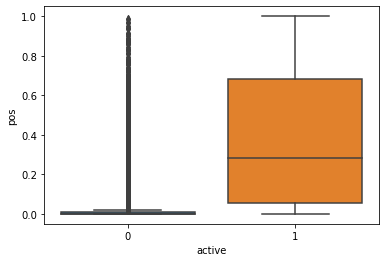

In [ ]:
# plot predicted probabilities for active and inactives
sns.boxplot(x=pred_df.active, y=pred_df.pos);

In [ ]:
# put false negatives in a new dataframe
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_negative_df, 'SMILES', 'Mol')

In [ ]:
type(valid_dataset)

deepchem.data.datasets.DiskDataset

,neg,pos,active,SMILES,Mol
16849,0.652027,0.347973,1,COc1ccc(CNCCC(c2ccccc2)C2CCOC(C)(C)C2)cc1,
21014,0.920934,0.079066,1,c1ccc(C(c2ccccc2)c2noc(CN3CCN(CC4CC4)CC3)n2)cc1,
11563,0.622856,0.377144,1,COc1cc(CN2CCC(CCC(=O)NC3CC3)CC2)cc(Cl)c1OC,
11702,0.559105,0.440895,1,O=C(CN1CCN(Cc2ccc(Cl)cc2)CC1)N/N=C/c1ccncc1,
18031,0.692768,0.307232,1,C=CCN(c1ccccc1)S(=O)(=O)c1cccc(C(=O)NC2CCN(Cc3...,

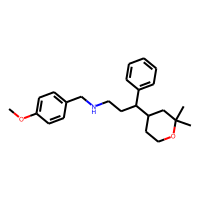
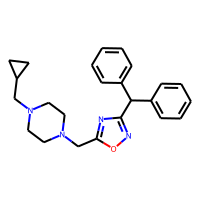
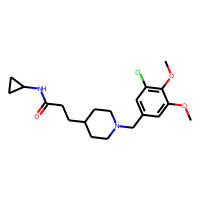
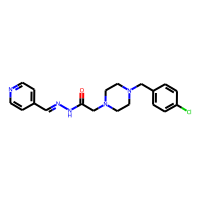
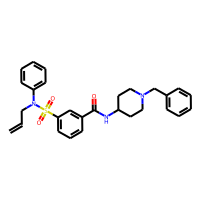

In [ ]:
show(false_negative_df.sample(5))

In [ ]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df, 'SMILES', 'Mol')

,neg,pos,active,SMILES,Mol
23687,0.058787,0.941213,0,CCc1ccccc1NC(=O)CN1CCN(CC(=O)NCc2ccc(Cl)cc2)CC1,
6258,0.207830,0.792170,0,COc1ccc(F)cc1C(=O)C1CCCN(Cc2cn(C)c3ccccc23)C1,
5257,0.429260,0.570740,0,Cl.OC(COc1c(F)cc(Br)cc1F)CN1CCN(c2ccc(F)cc2)CC1,
21501,0.193804,0.806196,0,CCc1ccc(NC(=O)CSc2nc(=O)n(CCN(C)C)c3c2CCCC3)cc1,
9692,0.467457,0.532543,0,O=c1c2ccccc2nc(-c2ccccc2)n1CCCn1ccnc1,

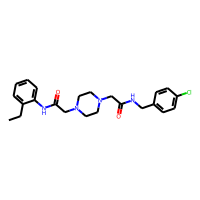
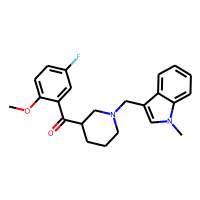
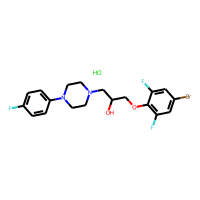
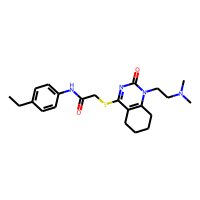
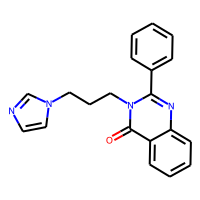

In [ ]:
show(false_positive_df.sample(5))

In [ ]:
false

### Create Keras model

In [ ]:
def conv_net():
  K.clear_session()
  weights = 'imagenet'
  inputs = Input(shape=(128, 128, 3))

  base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

  for layer in base_model.layers:
    layer.trainable = False

  x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Flatten()(x)

  base_resnet = base_model(inputs)
  base_resnet = Flatten()(base_resnet)

  concated_layers = Concatenate()([x, base_resnet])

  concated_layers = Dense(2024, activation='relu')(concated_layers)
  concated_layers = Dense(524, activation='relu')(concated_layers)
  concated_layers = Dense(124, activation='relu')(concated_layers)
  output = Dense(4, activation='relu')(concated_layers)

  model = Model(inputs=inputs, outputs=output)
  return model